In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [2]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
train_df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [4]:
train_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [5]:
train_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
category_train_df = train_df[['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage','Response','Driving_License']]
continuous_train_df = train_df[['Age','Annual_Premium','Vintage']]


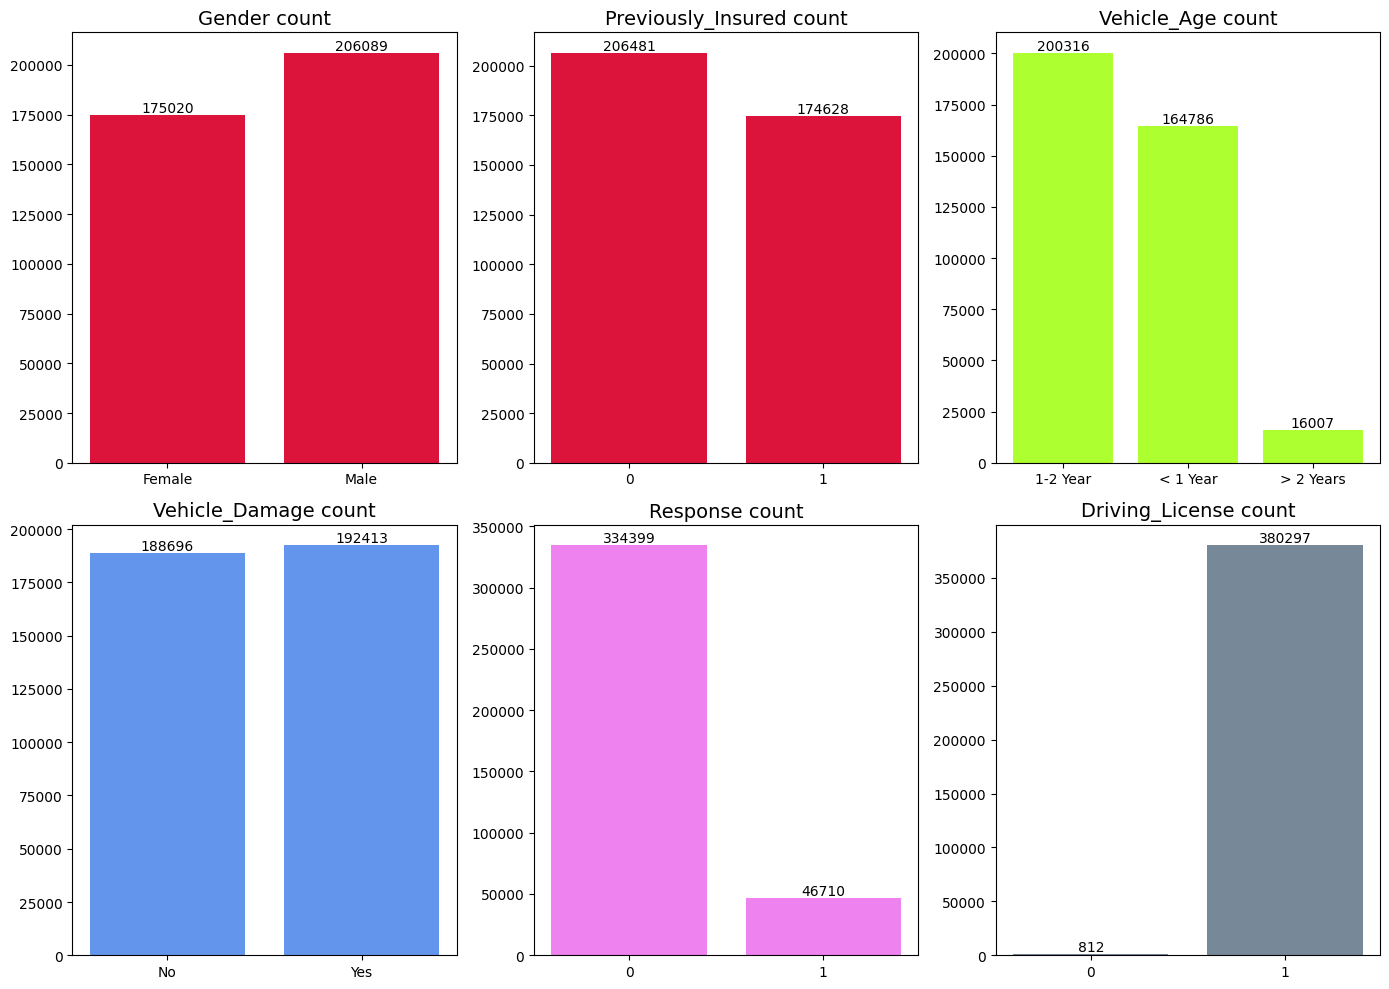

In [ ]:
   
plt.figure(figsize=(14,10))
color_ls = ['#DC143C','#DC143C','#ADFF2F','#6495ED','#EE82EE','#778899']
for i in range(6):
    plt.subplot(2,3,i + 1)
    plt.title(category_train_df.columns[i] + ' count',fontsize=14)
    col_count = category_train_df[category_train_df.columns[i]].value_counts().sort_index()
    plt.bar(col_count.index,col_count.values,color=color_ls[i])
    plt.xticks(col_count.index)
    for i in range(len(col_count)):
        plt.text(i,col_count.values[i],str(col_count.values[i]),va='bottom',ha='center')
plt.tight_layout()
plt.show()

In [8]:
continuous_train_df.describe()

,Age,Annual_Premium,Vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


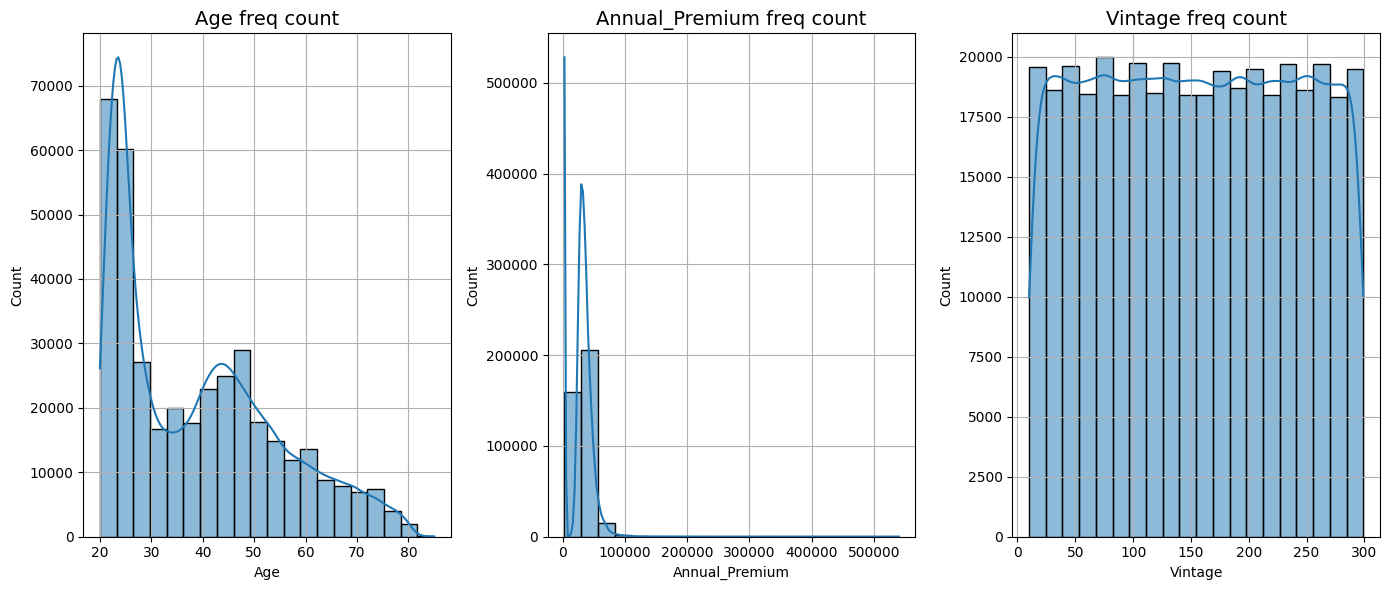

In [9]:
fig,ax = plt.subplots(1,3,figsize=(14,6))
for i in range(3):
    sns.histplot(continuous_train_df[continuous_train_df.columns[i]],ax=ax[i],kde=True,bins=20)
    ax[i].set_title(continuous_train_df.columns[i] + ' freq count',fontsize=14)
    ax[i].grid()
plt.tight_layout()
plt.show()

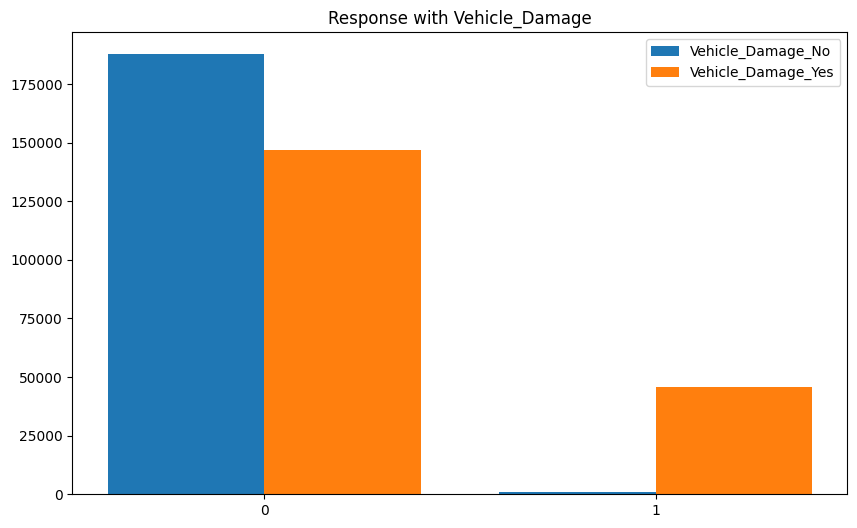

In [10]:
is_damage = train_df.groupby(['Vehicle_Damage','Response']).agg({"id":'count'}).rename({'id':'Count'},axis=1).reset_index()
no_damage = is_damage[is_damage['Vehicle_Damage'] == 'No']
yes_damage = is_damage[is_damage['Vehicle_Damage'] == 'Yes']
plt.figure(figsize=(10,6))
plt.bar(no_damage['Response'] - 0.20,no_damage['Count'],width=0.4,label='Vehicle_Damage_No')
plt.bar(yes_damage['Response'] + 0.20,yes_damage['Count'],width=0.4,label='Vehicle_Damage_Yes')
plt.xticks(yes_damage['Response'])
plt.title('Response with Vehicle_Damage')
plt.legend()
plt.show()

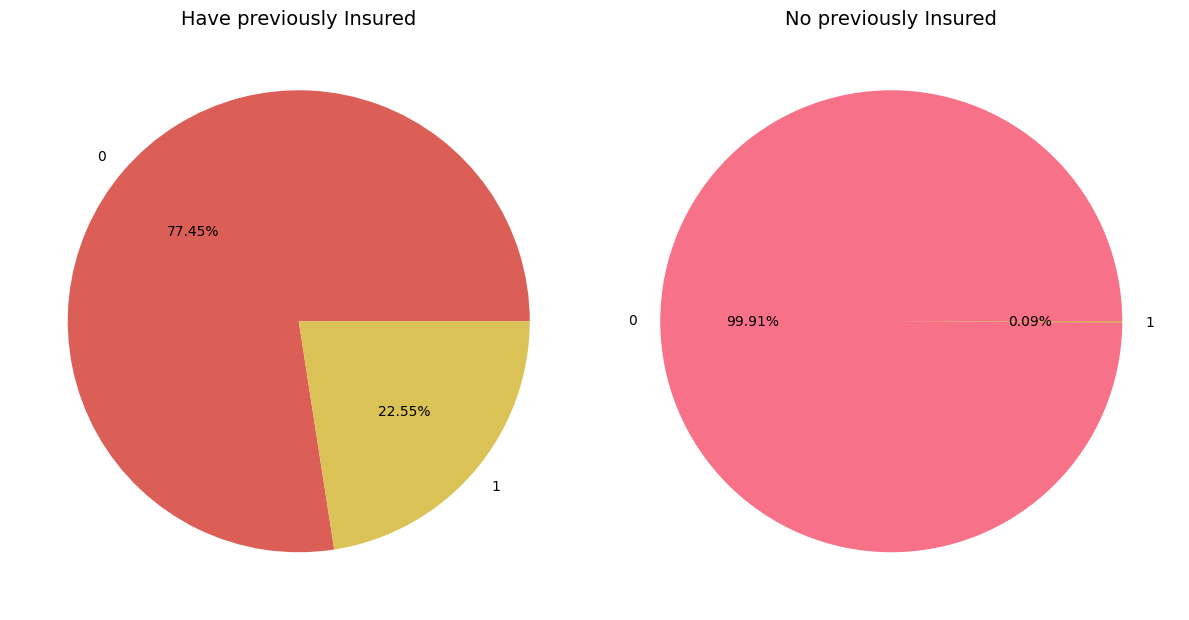

In [11]:
is_prev = train_df.groupby(['Previously_Insured','Response']).agg({'id':'count'}).rename({'id':'Count'},axis=1).reset_index()
prev = is_prev[is_prev['Previously_Insured'] == 0]
no_prev = is_prev[is_prev['Previously_Insured'] == 1]
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pie(prev['Count'],labels=prev['Response'],autopct='%.2f%%',colors=sns.color_palette("hls", 8))
plt.title('Have previously Insured',fontsize=14)

plt.subplot(1,2,2)
plt.pie(no_prev['Count'],labels=no_prev['Response'],autopct='%.2f%%',colors=sns.color_palette("husl", 8))
plt.title('No previously Insured',fontsize=14)

plt.tight_layout()
plt.show()

In [12]:
indicate_region = pd.DataFrame()
for i in train_df['Region_Code'].value_counts().iloc[:8].index:
    indicate_region = pd.concat([indicate_region,train_df[train_df['Region_Code'] == i]])

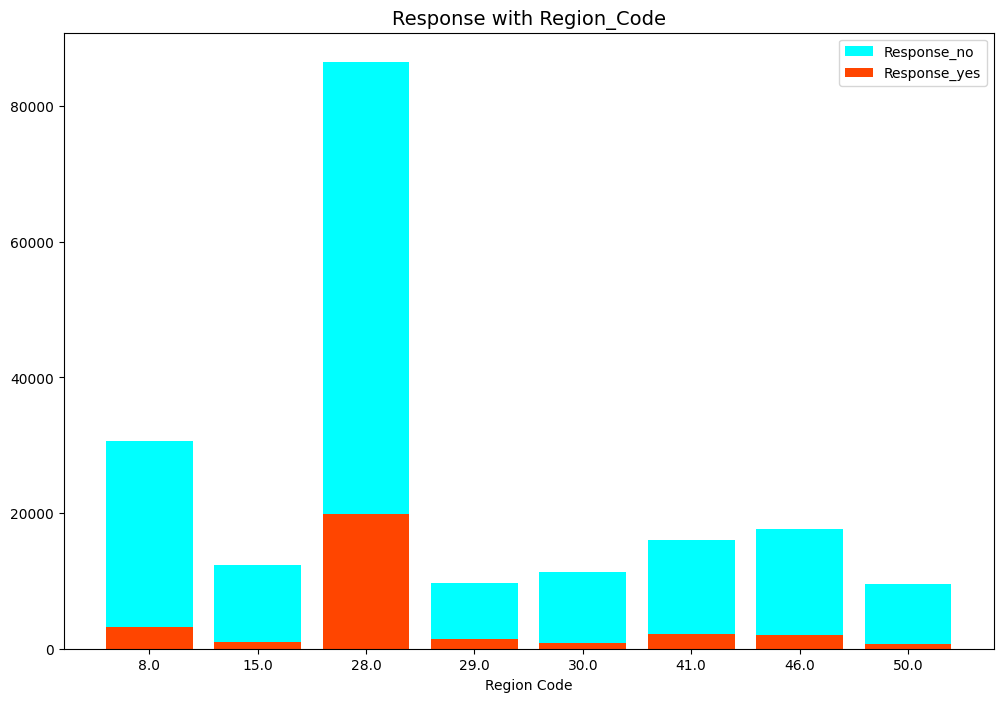

In [13]:
region_response = indicate_region.groupby(['Region_Code','Response']).agg({'id':'count'}).rename({'id':'Count'},axis=1).reset_index()
no_response = region_response[region_response['Response'] == 0]
yes_response = region_response[region_response['Response'] == 1]
plt.figure(figsize=(12,8))
plt.bar(no_response['Region_Code'].astype('str'),no_response['Count'],color='#00FFFF',label='Response_no')
plt.bar(yes_response['Region_Code'].astype('str'),yes_response['Count'],color='#FF4500',label='Response_yes')
plt.title('Response with Region_Code',fontsize=14)
plt.xlabel('Region Code')
plt.legend()
plt.show()

In [14]:
des_train_df = train_df['Vintage'].describe()
def level_func(x):
    if x >= des_train_df['75%']:
        return 'high'
    elif x > des_train_df['50%'] and x < des_train_df['75%']:
        return 'mid'
    else:
        return 'low'
train_df['customer_level'] = train_df['Vintage'].apply(level_func)

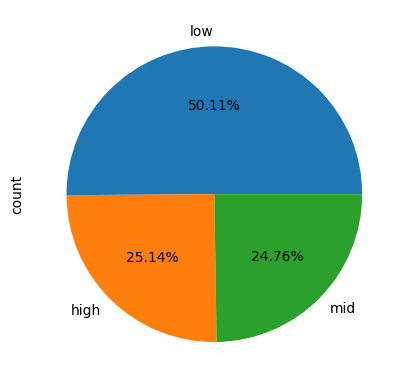

In [15]:
train_df['customer_level'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

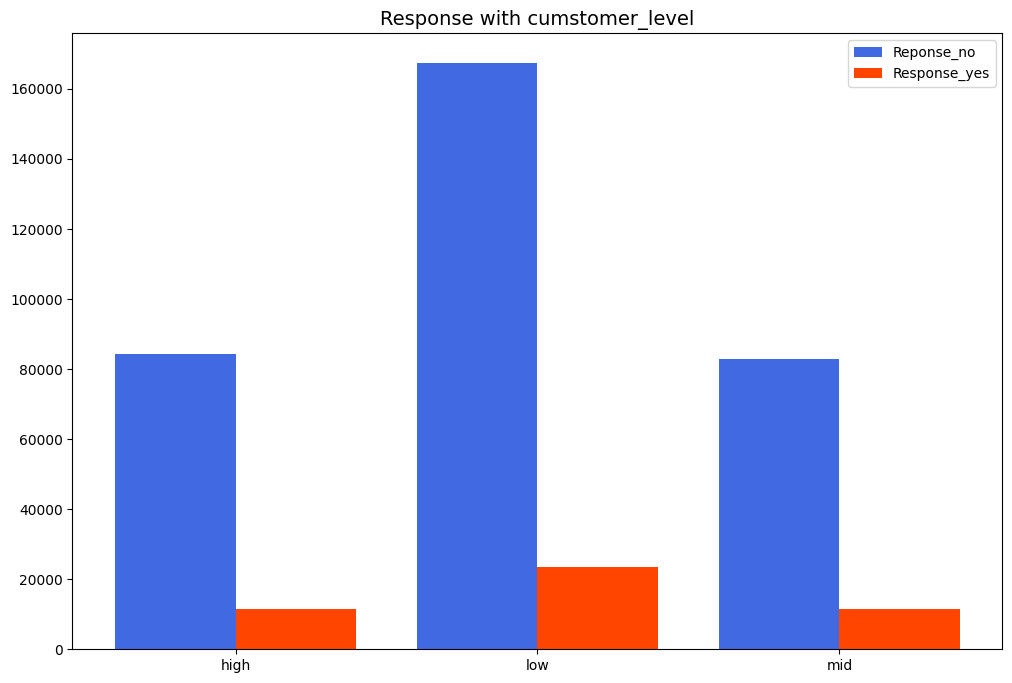

In [ ]:
 
res = train_df.groupby(['customer_level','Response']).agg({'id':'count'}).rename({'id':'Count'},axis=1).reset_index()
no_res = res[res['Response'] == 0]
yes_res = res[res['Response'] == 1]
plt.figure(figsize=(12,8))
plt.bar(np.array(range(len(no_res))) - 0.2,no_res['Count'],width=0.4,label='Reponse_no',color='#4169E1')
plt.bar(np.array(range(len(yes_res))) + 0.2,yes_res['Count'],width=0.4,label='Response_yes',color='#FF4500')
plt.xticks(range(len(no_res)),no_res['customer_level'])
plt.title('Response with cumstomer_level',fontsize=14)
plt.legend()
plt.show()

In [17]:
train_df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,customer_level
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,mid
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,mid
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,low
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,mid
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0,low
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0,low
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0,mid
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0,low


In [18]:
data_features = pd.concat([category_train_df,continuous_train_df],axis=1)
data_features['Region_Code'] = train_df['Region_Code']
data_features['Policy_Sales_Channel'] = train_df['Policy_Sales_Channel']

In [ ]:

# ---------------------------
# 1. Read & Prepare Features
# ---------------------------
X = data_features.drop(columns=['Response'])
y = data_features['Response']

# ---------------------------
# 2. Train/Test Split (before any fitting!)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 3. Encode Categoricals (fit only on train)
# ---------------------------
cat_cols = ['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col]  = le.transform(X_test[col])   # no .fit() again
    encoders[col] = le   # save if you need later

# ---------------------------
# 4. Scale Continuous Features (fit only on train)
# ---------------------------
scaler = MinMaxScaler()
X_train[['Age','Annual_Premium','Vintage']] = scaler.fit_transform(X_train[['Age','Annual_Premium','Vintage']])
X_test[['Age','Annual_Premium','Vintage']]  = scaler.transform(X_test[['Age','Annual_Premium','Vintage']])

# ---------------------------
# 5. Apply SMOTE on training set
# ---------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ---------------------------
# 6. Train Model
# ---------------------------
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb.fit(X_train_res, y_train_res)

# ---------------------------
# 7. Evaluate
# ---------------------------
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


C:\Users\riadh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [16:13:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test ROC-AUC: 0.8442197668168349
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     66880
           1       0.32      0.69      0.43      9342

    accuracy                           0.78     76222
   macro avg       0.63      0.74      0.65     76222
weighted avg       0.87      0.78      0.81     76222



In [ ]:


# 1. Read & Prepare Features
# ---------------------------
X = data_features.drop(columns=['Response'])
y = data_features['Response']

# ---------------------------
# 2. Train/Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 3. Encode Categoricals (fit only on train)
# ---------------------------
cat_cols = ['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col]  = le.transform(X_test[col])
    encoders[col] = le

# ---------------------------
# 4. Scale Continuous Features (fit only on train)
# ---------------------------
scaler = MinMaxScaler()
X_train[['Age','Annual_Premium','Vintage']] = scaler.fit_transform(X_train[['Age','Annual_Premium','Vintage']])
X_test[['Age','Annual_Premium','Vintage']]  = scaler.transform(X_test[['Age','Annual_Premium','Vintage']])

# ---------------------------
# 5. Apply SMOTE on training set
# ---------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ---------------------------
# 6. Train Logistic Regression Model
# ---------------------------
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000,      # ensure convergence
    class_weight='balanced'  # optional to handle imbalance
)
logreg.fit(X_train_res, y_train_res)

# ---------------------------
# 7. Evaluate
# ---------------------------
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Test ROC-AUC: 0.8223098896632896
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.98      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



In [ ]:

# 1. Read & Prepare Features
# ---------------------------
X = data_features.drop(columns=['Response'])
y = data_features['Response']

# ---------------------------
# 2. Train/Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 3. Encode Categoricals (fit only on train)
# ---------------------------
cat_cols = ['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col]  = le.transform(X_test[col])
    encoders[col] = le

# ---------------------------
# 4. Scale Continuous Features (fit only on train)
# ---------------------------
scaler = MinMaxScaler()
X_train[['Age','Annual_Premium','Vintage']] = scaler.fit_transform(X_train[['Age','Annual_Premium','Vintage']])
X_test[['Age','Annual_Premium','Vintage']]  = scaler.transform(X_test[['Age','Annual_Premium','Vintage']])

# ---------------------------
# 5. Apply SMOTE on training set
# ---------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ---------------------------
# 6. Train Random Forest Model
# ---------------------------
rf = RandomForestClassifier(
    n_estimators=200,    # number of trees
    random_state=42,
    class_weight='balanced'  # handle imbalance
)
rf.fit(X_train_res, y_train_res)

# ---------------------------
# 7. Evaluate
# ---------------------------
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Test ROC-AUC: 0.8324130804866944
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     66880
           1       0.32      0.47      0.38      9342

    accuracy                           0.81     76222
   macro avg       0.62      0.67      0.64     76222
weighted avg       0.85      0.81      0.83     76222



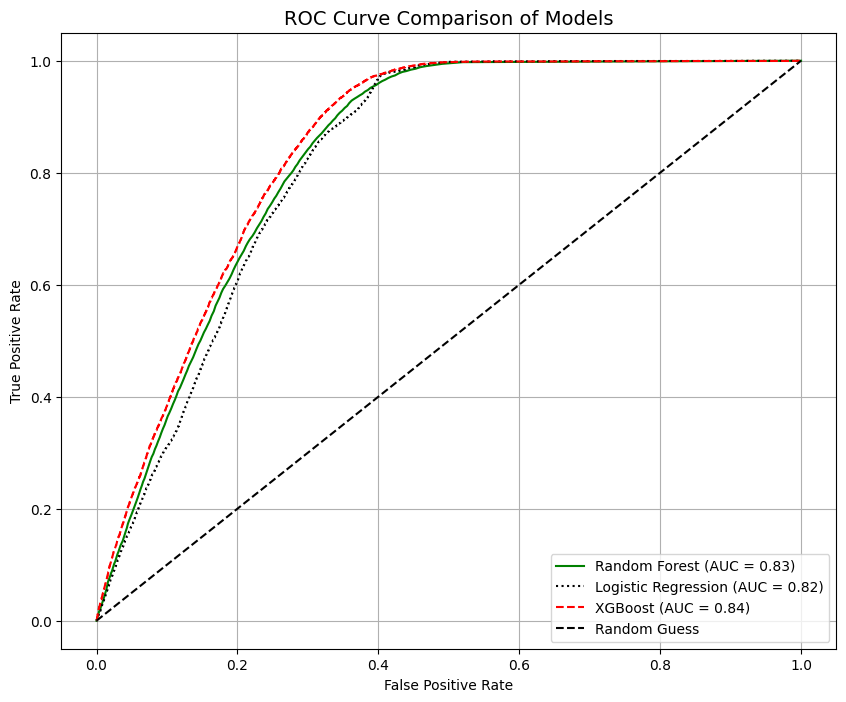

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---------------------------
# Collect Models & Names
# ---------------------------
model_ls = [rf, logreg, xgb]   # your trained models
model_name = ['Random Forest', 'Logistic Regression', 'XGBoost']
colors = ['green', 'black', 'red']
linestyles = ['-', ':', '--']

# ---------------------------
# Plot ROC Curves
# ---------------------------
plt.figure(figsize=(10, 8))
plt.title('ROC Curve Comparison of Models', fontsize=14)

for model, c, l, name in zip(model_ls, colors, linestyles, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # probabilities for class 1
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=c, linestyle=l, 
             label="{} (AUC = {:.2f})".format(name, roc_auc))

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [37]:
test_category_data = test_df[['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage','Driving_License']]
test_continuous_data = test_df[['Age','Annual_Premium','Vintage']]
test_data_features = pd.concat([test_category_data,test_continuous_data],axis=1)
test_data_features.insert(0,'id',test_df['id'])
test_data_features['Region_Code'] = test_df['Region_Code']
test_data_features['Policy_Sales_Channel'] = test_df['Policy_Sales_Channel']

In [38]:
# ---------------------------
# 2. Apply SAME preprocessing
# ---------------------------
# Encode categoricals with previously fitted encoders
for col in ['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage']:
    test_data_features[col] = encoders[col].transform(test_data_features[col])

# Scale continuous features with same scaler
test_data_features[['Age','Annual_Premium','Vintage']] = scaler.transform(
    test_data_features[['Age','Annual_Premium','Vintage']]
)

# ---------------------------
# 3. Final Test Features
# ---------------------------
X_test_final = test_data_features.drop(columns=['id'])

# ---------------------------
# 4. Predict with trained XGB model
# ---------------------------
y_pred = xgb.predict(X_test_final)
y_pred_proba = xgb.predict_proba(X_test_final)[:, 1]

# ---------------------------
# 5. Build Submission File
# ---------------------------
submission = pd.DataFrame({
    'id': test_data_features['id'],
    'Response': y_pred,
    'Response_Prob': y_pred_proba
})

print(submission.head())


       id  Response  Response_Prob
0  381110         0       0.002030
1  381111         1       0.565560
2  381112         1       0.663656
3  381113         0       0.011524
4  381114         0       0.000776


In [39]:
submission

,id,Response,Response_Prob
0,381110,0,0.002030
1,381111,1,0.565560
2,381112,1,0.663656
3,381113,0,0.011524
4,381114,0,0.000776
...,...,...,...
127032,508142,0,0.000570
127033,508143,1,0.742774
127034,508144,0,0.000883
127035,508145,0,0.001047


In [42]:
submission.to_csv("submission.csv", index=False)